In [ ]:
# setup 
!pip install labelme albumentations

# Get Data

### Collect Images Using OpenCV

In [1]:
import os
import time
import uuid # allows to make a uniform unique identifier 
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
    print(f'Collecting Image {img_num}')
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### Annotate Images with Labelme

In [7]:
!labelme

2025-01-03 23:22:29.714 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\Lenovo\.labelmerc


# Review Dataset and Build Image Loading Function

In [3]:
import tensorflow as tf 
import json 
import numpy as np 
import matplotlib.pyplot as plt 

c:\Users\Lenovo\anaconda3\envs\MachineLearning\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### Load image into TF Data Pipeline

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)

In [26]:
images.as_numpy_iterator().next()

b'data\\images\\9a6dadbb-c9f9-11ef-8bd5-3e4ec903c601.jpg'

In [18]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [27]:
images = images.map(load_image)

In [28]:
images.as_numpy_iterator().next()

array([[[204, 188, 189],
        [204, 188, 189],
        [201, 182, 186],
        ...,
        [101,  97,  96],
        [103,  99, 100],
        [105, 101, 102]],

       [[200, 184, 185],
        [200, 184, 185],
        [199, 180, 182],
        ...,
        [100,  96,  95],
        [101,  97,  98],
        [102,  98,  99]],

       [[202, 186, 186],
        [202, 186, 186],
        [201, 183, 183],
        ...,
        [ 99,  98,  96],
        [101,  97,  96],
        [101,  97,  96]],

       ...,

       [[ 35,  35,  47],
        [ 41,  41,  53],
        [ 43,  43,  55],
        ...,
        [ 61,  63,  75],
        [ 62,  64,  76],
        [ 64,  66,  78]],

       [[ 35,  34,  48],
        [ 39,  38,  52],
        [ 42,  41,  55],
        ...,
        [ 62,  62,  74],
        [ 64,  64,  76],
        [ 66,  66,  78]],

       [[ 37,  36,  50],
        [ 35,  34,  48],
        [ 37,  36,  50],
        ...,
        [ 63,  63,  75],
        [ 65,  65,  77],
        [ 66,  66,  78]]

### View Raw Images with Matplotlib

In [29]:
image_generator = images.batch(4).as_numpy_iterator()

In [32]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# Partition Unaugmented Data

#### Manually split the data into TRAIN TEST and VAL 


In [36]:
90 * 0.7 # 63 images to train
90 * 0.15 # 14 images to test and 13 to val

13.5

### Move the Matching Lables 

In [37]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# Apply Image Augmentation on Images and Labels Using Albumentations

#### Setup Albumentation Transform Pipeline

In [15]:
import albumentations as alb

c:\Users\Lenovo\anaconda3\envs\MachineLearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

c:\Users\Lenovo\anaconda3\envs\MachineLearning\Lib\site-packages\pydantic\main.py:390: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...6, 0.0784313725490196)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


#### Load a Test Image and Annotation with OpenCV and JSON

In [49]:
img = cv2.imread(os.path.join('data', 'train', 'images', '5e66f658-c9fa-11ef-bf71-3e4ec903c601.jpg'))

In [50]:
img.shape

(480, 640, 3)

In [51]:
with open(os.path.join('data', 'train', 'labels', '5e66f658-c9fa-11ef-bf71-3e4ec903c601.json'), 'r') as f:
    label = json.load(f)

#### Extract the Coordinates and Rescale to Match Image Resolution 

In [52]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [53]:
coords

[268.8950276243094, 218.45303867403314, 374.9723756906078, 339.44751381215474]

In [54]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [55]:
coords

[0.4201484806629835, 0.455110497237569, 0.5858943370165747, 0.707182320441989]

#### Apply Augmentation and View Results

In [56]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [57]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

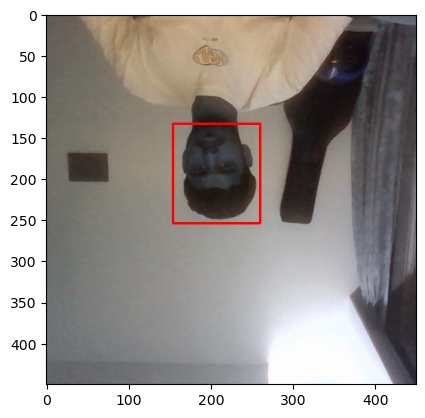

In [58]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

In [59]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
            
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0
                    
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
                    
        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [6.89485490e-01 8.67173135e-01 1.84880450e-01 1.18423795e-16
 0.00000000e+00].


c:\Users\Lenovo\anaconda3\envs\MachineLearning\Lib\site-packages\albumentations\core\bbox_utils.py:488: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


x_max is less than or equal to x_min for bbox [0.99680597 0.29396871 0.84832525 0.53107733 0.        ].


#### Load Augmented Images to Tensorflow Dataset

In [62]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [63]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [64]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

# Prepare Labels

In [69]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [70]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [71]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [72]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [73]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4028, 0.166 , 0.744 , 0.5747], dtype=float16))

# Combine label and Image Samples

In [74]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3660, 3660, 900, 900, 840, 840)

#### Create Final Datasets

In [75]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [76]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [77]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8) 
val = val.prefetch(4)

In [78]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

# Build Deep Learning Model Using Functional API 

In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [82]:
vgg = VGG16(include_top=False)

In [83]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding Box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2]) 
    return facetracker   
    

In [85]:
facetracker = build_model()

In [86]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      2,049 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      8,196 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

#### Test on NN

In [87]:
X, y = train.as_numpy_iterator().next()

In [88]:
X.shape

(8, 120, 120, 3)

In [89]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


In [90]:
classes, coords

(array([[0.6079167 ],
        [0.5383025 ],
        [0.5687705 ],
        [0.56432074],
        [0.58820224],
        [0.5675637 ],
        [0.580632  ],
        [0.5643816 ]], dtype=float32),
 array([[0.5824975 , 0.48638478, 0.4736227 , 0.62119997],
        [0.57828856, 0.4342898 , 0.49449545, 0.6154046 ],
        [0.57420135, 0.37239096, 0.48758528, 0.6389396 ],
        [0.53474355, 0.4376472 , 0.46811506, 0.6302163 ],
        [0.49578017, 0.4011362 , 0.49121755, 0.59654593],
        [0.5762073 , 0.3642174 , 0.52326715, 0.63167036],
        [0.58450294, 0.43548757, 0.48246375, 0.63638484],
        [0.548995  , 0.45488164, 0.33142176, 0.58822864]], dtype=float32))

# Define Losses and Optimizers


In [36]:
len(train)

458

In [91]:
batches_per_epoch = len(train)
initial_lr = 0.0001
decay_steps = batches_per_epoch # decay after each epoch
decay_rate = (1. / 0.75 - 1)

In [92]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_lr,
    decay_steps = decay_steps,
    decay_rate = decay_rate
)

In [93]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [94]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [95]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

#### Test on losses


In [96]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5683503>

In [97]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7239936>

In [98]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5683503>

# Train Neural Network

In [99]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [100]:
model = FaceTracker(facetracker)

In [101]:
model.compile(opt, classloss, regressloss)

In [102]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.